# Pytorch Practice : BERT

In [0]:
#@title VIDEO : Training Sentiment Model Using BERT and Serving it with Flask API
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/hinZO--TEk4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Import Data

Install Hugging Face Transformer 🤗

https://github.com/huggingface/transformers

In [0]:
! pip install transformers

     |████████████████████████████████| 665kB 5.8MB/s 
     |████████████████████████████████| 1.1MB 17.0MB/s 
     |████████████████████████████████| 890kB 104kB/s 
     |████████████████████████████████| 3.8MB 11.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=2bade97aa43c7fa52706fe4dd6d08a9ba75e36006a54c4afd4f6c0d934cbd8fd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
! pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=9524072be17a52f5e8ffd027caf322be018a4fd182e92d807df6d839d4be948a
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
import pandas as pd

train_df = pd.read_csv('https://raw.githubusercontent.com/suakow/twitter_sentiment-bert/master/dis_tweet_train.csv')

time: 397 ms


In [0]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


time: 28.6 ms


In [0]:
train_df.shape

(7613, 5)

time: 3.31 ms


In [0]:
pd.crosstab(train_df['target'], columns=['c'])

col_0,c
target,
0,4342
1,3271


time: 40.2 ms


Define model property.

In [0]:
import transformers

MAX_Len = 512 
TRAIN_BATCH_SIZE = 8 
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 8
BERT_PATH = 'bert-base-uncased'
TOKENZIER = transformers.BertTokenizer.from_pretrained(BERT_PATH ,do_lower_case = True )


time: 6.11 s


# Define Dataset

In [0]:
class BERTDataset : 
    def __init__(self,df) : 
        self.text = df['text'].values
        self.target = df['target'].values 
        self.tokenizer = TOKENZIER 
        self.max_len = MAX_Len 

    def __len__(self) : 
        return len(self.text)
        
    def __getitem__(self, item):
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=self.max_len
            )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        padding_length = self.max_len - len(ids)
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)

        return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.target[item], dtype=torch.float)
            }

time: 22 ms


In [0]:
train_df = train_df[['text', 'target']]

time: 4.32 ms


In [0]:
train_df.isnull().any()

text      False
target    False
dtype: bool

time: 22.5 ms


In [0]:
from sklearn.model_selection import train_test_split
test_size = 0.2
val_size = 0.1

new_X, X_test = train_test_split(train_df, test_size=test_size, random_state=55,stratify = train_df['target'].values)
X_train, X_val = train_test_split(new_X, test_size=(val_size/(1-test_size)), random_state=55,stratify = new_X['target'].values)

time: 30.1 ms


In [0]:
X_train.shape

(5328, 2)

time: 3.43 ms


In [0]:
X_val.shape

(762, 2)

time: 2.67 ms


In [0]:
X_test.shape

(1523, 2)

time: 2.66 ms


In [0]:
import torch

TRAIN_BATCH_SIZE = 8 
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 8

train_dataloader = torch.utils.data.DataLoader(BERTDataset(X_train), batch_size=TRAIN_BATCH_SIZE)
valid_dataloader = torch.utils.data.DataLoader(BERTDataset(X_val), batch_size=VALID_BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(BERTDataset(X_test), batch_size=TEST_BATCH_SIZE)

time: 6.13 ms


# Create Model

In [0]:
import torch

class BertBaseUncased(torch.nn.Module) :
    def __init__(self) : 
        super(BertBaseUncased,self).__init__() 
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH) 
        self.bert_drop = torch.nn.Dropout(0.4) 
        self.out = torch.nn.Linear(768,1)
        
    def forward(self,ids,mask,token_type_ids) : 
        out1, out2 = self.bert( 
            ids , 
            attention_mask = mask , 
            token_type_ids = token_type_ids 
        )
        bo = self.bert_drop(out2) 
        output = self.out(bo) 
        return output 

time: 10.6 ms


In [0]:
def loss_fn(outputs, targets) :
    return torch.nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

time: 1.62 ms


In [0]:
import tqdm

def train_fn(data_loader, model, optimizer, scheduler):
    model.train()

    for bi, d in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

time: 18.3 ms


In [0]:
def eval_fn(data_loader, model):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

time: 17.7 ms


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

DEVICE =torch.device("cuda")
device = torch.device("cuda")

def run(model, EPOCHS, train_data_loader, valid_data_loader):
    device = torch.device("cuda")
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(train_data_loader)) * EPOCHS
    optimizer = torch.optim.AdamW(optimizer_parameters, lr=1e-5)
    scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    model = torch.nn.DataParallel(model)

    best_accuracy = 0

    for epoch in range(EPOCHS):
        print('epoch : %s'%(epoch+1))
        train_fn(train_data_loader, model, optimizer, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model)
        outputs = np.array(outputs) >= 0.5
        accuracy = accuracy_score(targets, outputs)
        print('')
        print(f"Accuracy Score = {accuracy}")
        scheduler.step()

time: 44.3 ms


In [0]:
import tqdm

model = BertBaseUncased()
model.to(device)
getattr(tqdm, '_instances', {}).clear()


time: 27.3 s


In [0]:
run(model, 2, train_dataloader, valid_dataloader)

  0%|          | 0/666 [00:00<?, ?it/s]

epoch : 1


  0%|          | 0/666 [00:00<?, ?it/s]


Accuracy Score = 0.8110236220472441
epoch : 2


100%|██████████| 191/191 [00:49<00:00,  3.83it/s]


Accuracy Score = 0.8254593175853019
time: 33min 36s


In [0]:
y_pred, y_true = eval_fn(test_dataloader, model)
y_pred = np.array(y_pred) >= 0.5
accuracy = accuracy_score(y_true, y_pred)

100%|██████████| 191/191 [01:37<00:00,  1.95it/s]

time: 1min 37s


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Classification Report :
              precision    recall  f1-score   support

         0.0      0.844     0.849     0.847       869
         1.0      0.798     0.792     0.795       654

    accuracy                          0.825      1523
   macro avg      0.821     0.821     0.821      1523
weighted avg      0.825     0.825     0.825      1523

Confusion Matrix :
[[738 131]
 [136 518]]


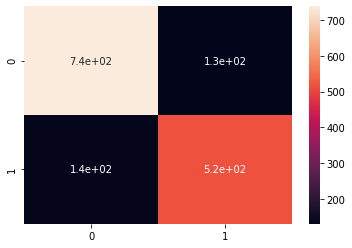

time: 364 ms


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print('Classification Report :')
print(classification_report(y_true, y_pred, output_dict=False, digits=3))
print('Confusion Matrix :')
print(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)